In [1]:
import unrelpix as urp

import numpy as np
import matplotlib.pyplot as plt
import glob
import os

CRDS local filepath: /home/fran/crds_cache
CRDS file server: https://jwst-crds.stsci.edu


In [2]:
working_dir = '/home/fran/data/'

In [3]:
ramp_files = glob.glob(working_dir + '*_ramp.fits')
rateints_files = glob.glob(working_dir + '*_rateints.fits')

In [ ]:
for file in ramp_files:
    urp.classification.process_fits_file(
        file,
        search_radius = 5,  
        window_radius = 3, 
        var_min = 0.5, 
        n_jobs = -1,
        output_dir = f'{working_dir}output/'
        ) # Process each FITS file in the directory, example parameters

In [ ]:
modified_files = glob.glob(working_dir + 'output/*_ramp_modified.fits') # Modified FITS files directory

for file in modified_files:
    urp.rampfitting.run_ramp_fitting(
        file,
        output_dir = f'{working_dir}output/'
    ) # Run ramp fitting on modified FITS files

In [ ]:
rampfitted_files = glob.glob(working_dir + 'output/*_rampfitted.fits') # Ramp fitted files directory

for file in rampfitted_files:
    urp.interpolation.interpolate_fits_file(
    file,
    max_radius = 3,
    iterations = 5,
    print_errors = False
    ) # Interpolate the ramp fitted files

In [4]:
interpolated_files = glob.glob(working_dir + 'output/*_interpolated.fits') # Interpolated files directory

In [ ]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

# Define a function to process and normalize data
def process_data(file_path, interp_path):
    with fits.open(file_path) as hdul:
        data = hdul[1].data
    with fits.open(interp_path) as hdul1:
        data_interp = hdul1[1].data

    data = [
        np.nansum([
            np.nansum(
                data[j, max(0, np.argmax(data_interp[j, :, i]) - 2):min(data.shape[1], np.argmax(data_interp[j, :, i]) + 2), i]
            )
            for i in range(data.shape[2])[:]
        ])
        for j in range(data.shape[0])
    ]
    return np.array(data) / np.nanmax(data)  # Normalize

# File groups
file_sets = [
    [rampfitted_files[i], rateints_files[i], interpolated_files[i]]
    for i in range(len(rampfitted_files))
]


# Use joblib to parallelize processing
def process_file_group(files):
    interp_path = files[2]
    return Parallel(n_jobs=-1)(
        delayed(process_data)(file_path, interp_path) for file_path in files
    )

# Process all file groups in parallel (groups still sequential, but files within each group in parallel)
total_data_sets = [process_file_group(files) for files in file_sets]

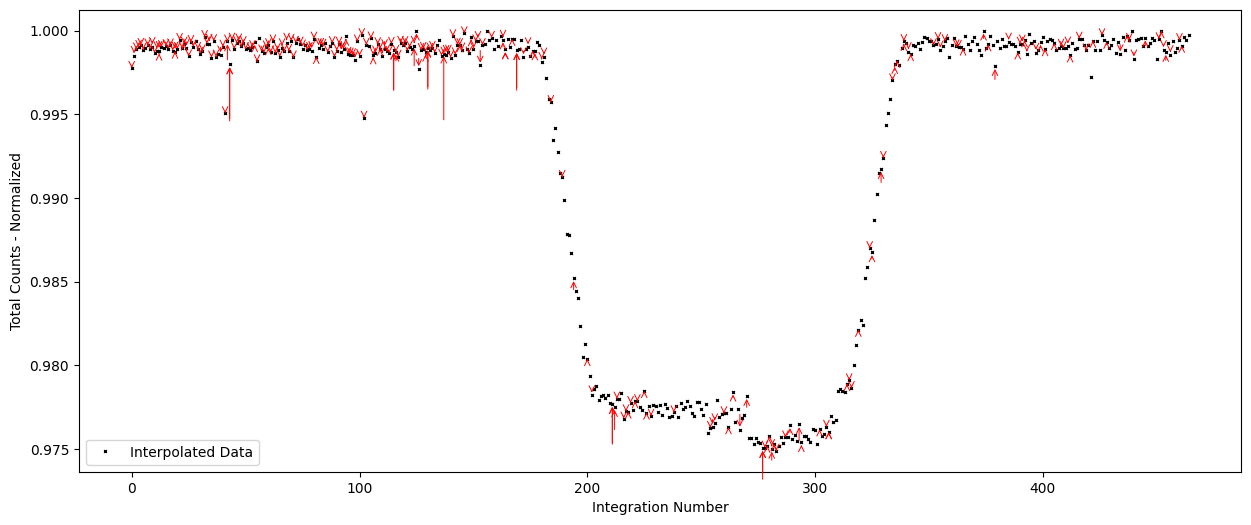

In [ ]:
labels = ['Interpolated Data']
colors = ['black']
markers = ['x']

fig, ax = plt.subplots(figsize=(15, 6))
offset = 0

for idx, group_data in enumerate(total_data_sets):
    extra_pixels_data = group_data[0].copy()  # Get the extra pixels identified data
    original_data = group_data[1].copy()  # Get the original data
    interpolated_data = group_data[2].copy()  # Get the interpolated data
    
    x_vals = np.arange(len(interpolated_data)) + offset
    ax.plot(x_vals, interpolated_data, markers[0], ms=2, color=colors[0], label=labels[0] if offset == 0 else None)
    offset += len(interpolated_data)

    for x, y_extra, y_interp in zip(x_vals, extra_pixels_data, interpolated_data):
        if abs(y_interp - y_extra) > 1e-4:
            ax.annotate(
                '', xy=(x, y_interp), xytext=(x, y_extra),
                arrowprops=dict(arrowstyle='->', color='red', lw=0.7)
            )
        # Plot arrows from extra_pixels_data to interpolated_data
    for x, y_extra, y_interp in zip(x_vals, original_data, interpolated_data):
        if abs(y_interp - y_extra) > 1e-4:
            ax.annotate(
                '', xy=(x, y_interp), xytext=(x, y_extra),
                arrowprops=dict(arrowstyle='->', color='red', lw=0.7)
            )

ax.set_xlabel('Integration Number')
ax.set_ylabel('Total Counts - Normalized')
ax.legend()
plt.show()
